In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import preprocess_input
from scipy.ndimage import gaussian_filter
import time

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    print('Loading file {} ...'.format(filename))
    dcm = pydicom.dcmread(filename) 
       
    body_part = dcm.BodyPartExamined.upper()
    if body_part != 'CHEST':
        print('Image {} rejected, Body part: {}'.format(filename, body_part))
        return None
    
    position = dcm.PatientPosition.upper()
    if position not in ['PA', 'AP']:
        print('Image {} rejected, Patient position: {}'.format(filename, position))
        return None
    
    modality = dcm.Modality.upper()
    if modality != 'DX':
        print('Image {} rejected, Modality: {}'.format(filename, modality))
        return None
    
    print('Loading successful!')
    
    findings = dcm.StudyDescription
    print('Findings:', findings)
    
    img = dcm.pixel_array
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_size):

    assert len(img.shape) == 2, "Image shape should be (H, W) | Input provided: {}".format(img.shape)
    
    normalized_img  = img / 255
    resized_img = resize(normalized_img, (img_size[1], img_size[2]))
    resized_img = np.repeat(resized_img.reshape((img_size[1], img_size[2], 1)), img_size[3], axis=2)
    blurred_img = preprocess(resized_img)
    proc_img = blurred_img.reshape(img_size)

    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):

    with open(model_path, 'r') as file:
        model_json = file.read()
        model = keras.models.model_from_json(model_json)
        model.load_weights(weight_path)    
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    
    prediction  = "Pneumonia" if (model.predict(img) > thresh) else "No Pneumonia"

    return prediction


def preprocess(image):
    """
    This function serves to remove small details like X-ray markers, tubes, ECG leads, catheters, etc. from the chest X-ray 
    and prepare the image to  be processed by the vgg16 model
    Filtering is done by appling a gaussian kernel on each channel of the image.
    The smoothing can be ajusted via the parameter sigma. Higher sigma corresponds to more blurring.
    """
    
    # Choose standard deviation for Gaussian kernel
    sigma = .5
    
    for c in range(image.shape[2]):
        image[:,:,c] = gaussian_filter(image [:,:,c], sigma=sigma, mode='nearest')
    
    image = preprocess_input(image)

    return image

**************************************************
Loading file test1.dcm ...
Loading successful!
Findings: No Finding
Pneumonia


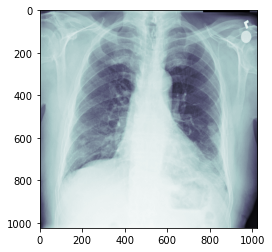

**************************************************
Loading file test2.dcm ...
Loading successful!
Findings: Cardiomegaly
Pneumonia


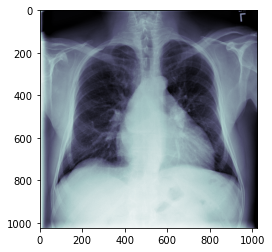

**************************************************
Loading file test3.dcm ...
Loading successful!
Findings: Effusion
Pneumonia


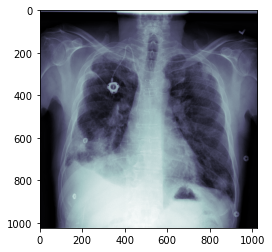

**************************************************
Loading file test4.dcm ...
Image test4.dcm rejected, Body part: RIBCAGE
**************************************************
Loading file test5.dcm ...
Image test5.dcm rejected, Modality: CT
**************************************************
Loading file test6.dcm ...
Image test6.dcm rejected, Patient position: XX
**************************************************


In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "xray_class_best_model.json"
weight_path = "xray_class_best_model_weights.hdf5"
threshold_path = "xray_class_best_threshold.npz"

img_size = (1, 224, 224, 3) # This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path)
with np.load(threshold_path) as data: # Loads the threshold
    thresh = data['arr_0']
# use the .dcm files to test your prediction
time_needed = []
for i in test_dicoms:
    
    start = time.time()
    
    print(50*'*') # Print line to seperate entries
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img, img_size)
    pred = predict_image(my_model, img_proc, thresh)
    print(pred)
    
    plt.imshow(img, cmap='bone') # Plot original image for reference

    plt.show()
    
    time_needed.append(time.time()-start)

print(50*'*')

In [4]:
print('Time needed on average: {} seconds '.format(np.round(sum(time_needed)/len(time_needed), 2)))

Time needed on average: 1.87 seconds 
